In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold, learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, accuracy_score, precision_recall_curve, PrecisionRecallDisplay, average_precision_score, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from sklearn.datasets import fetch_openml

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_decision_regions

import missingno as msno

from xgboost import XGBClassifier
from joblib import dump, load

warnings.filterwarnings('ignore')

# Predicting NBA Hall of Famers

Basketball fans often debate which NBA players will eventually make it to the Hall of Fame. It's a prestigious honor reserved for the best of the best, but predicting who will get there isn't straightforward. In this project, I'm trying to use machine learning to see if we can predict future Hall of Famers based on player stats and achievements. This is a classic binary classification task.

The starting dataset was this: https://www.kaggle.com/datasets/ryanschubertds/all-nba-aba-players-bio-stats-accolades/data. This includes players' data from 1947 to June 2022, after the 2022 Playoffs, the year where the Golden State Warriors, led by Steph Curry, won their 4th NBA Championship in the last 8 years.

The scope of this project is to create a model capable of accurately predicting whether a player is an hall of famer or not. We will train this model on the dataset composed of players that have been retired for 4 years or more (to get into the hall of fame a player must have been retired for at least 4 years). After the model has been trained we will use the model to predict which of the recently retired/currently playing players will be hall of famers or not.

## Cleaning NBA Player Data

In [2]:
players_df = pd.read_csv('input_data/NBA_players_clean.csv')

### Initial Investigation and Cleaning

Let's print the dataset to get an idea of what we're going to have to do to it.

In [3]:
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5023 entries, 0 to 5022
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Player             5023 non-null   object 
 1   From               5023 non-null   int64  
 2   To                 5023 non-null   int64  
 3   Years              5023 non-null   int64  
 4   Pos                5023 non-null   object 
 5   Ht                 5023 non-null   object 
 6   Height             5023 non-null   float64
 7   Wt                 5023 non-null   float64
 8   G                  5023 non-null   int64  
 9   PTS                5023 non-null   float64
 10  TRB                5023 non-null   float64
 11  AST                5023 non-null   float64
 12  FG%                5023 non-null   float64
 13  FG3%               5023 non-null   float64
 14  FT%                5023 non-null   float64
 15  eFG%               5023 non-null   float64
 16  PER                5023 

Since the starting dataset was very clean, I will add some noise to the dataset to simulate real-world data.
I will choose a random set of columns to add this data to.

In [4]:
def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace = False )
    X[indexes] = np.nan
    return X

In [5]:
noisy_cols = ['Wt', 'Scoring Champ', 'FG%', 'MVP', 'G', 'All ABA', 'Height', 'Finals MVP']

In [6]:
amount_of_noise = 0.06

for col in noisy_cols:
    if col in players_df.columns:
        players_df[col] = add_missing(players_df[col], amount_of_noise)
    else:
        print(f"Column {col} does not exist in the DataFrame.")

In [7]:
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5023 entries, 0 to 5022
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Player             5023 non-null   object 
 1   From               5023 non-null   int64  
 2   To                 5023 non-null   int64  
 3   Years              5023 non-null   int64  
 4   Pos                5023 non-null   object 
 5   Ht                 5023 non-null   object 
 6   Height             4722 non-null   float64
 7   Wt                 4722 non-null   float64
 8   G                  4722 non-null   float64
 9   PTS                5023 non-null   float64
 10  TRB                5023 non-null   float64
 11  AST                5023 non-null   float64
 12  FG%                4722 non-null   float64
 13  FG3%               5023 non-null   float64
 14  FT%                5023 non-null   float64
 15  eFG%               5023 non-null   float64
 16  PER                5023 

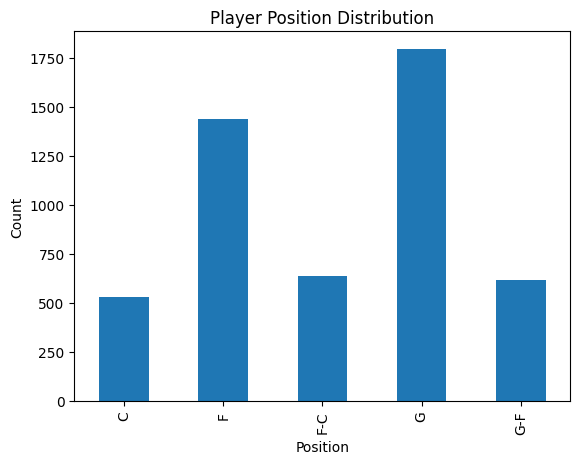

In [8]:
value_counts = players_df['Pos'].value_counts().sort_index()
value_counts.plot(kind='bar')
plt.title('Player Position Distribution')
plt.xlabel('Position')
plt.ylabel('Count')
plt.show()

In the above graph C refers to Center, F to Forward and G to Guard. The hybrid roles F-C or G-F are needed for players like Tim Duncan, who played as a Forward earlier in his career, then moved to the Center position, or LeBron James, who came into the NBA as a Guard, then transition to the Forward role.

In [9]:
players_df.head()

,Player,From,To,Years,Pos,Ht,Height,Wt,G,PTS,...,Sixth Man,DPOY,ROY,AS MVP,CF MVP,Finals MVP,MVP,Championships,NBA 75 Team,ABA All-Time Team
0,Alaa Abdelnaby,1991,1995,5,F-C,6-10,6.833333,240.0,256.0,5.7,...,0,0,0,0,0,0.0,0.0,0,0,0
1,Zaid Abdul-Aziz,1969,1978,10,F-C,6-9,6.750000,235.0,505.0,9.0,...,0,0,0,0,0,0.0,0.0,0,0,0
2,Kareem Abdul-Jabbar*,1970,1989,20,C,7-2,7.166667,225.0,1560.0,24.6,...,0,0,1,0,0,2.0,6.0,6,1,0
3,Mahmoud Abdul-Rauf,1991,2001,11,G,6-1,6.083333,162.0,586.0,14.6,...,0,0,0,0,0,0.0,0.0,0,0,0
4,Tariq Abdul-Wahad,1998,2003,6,F,6-6,6.500000,NaN,NaN,7.8,...,0,0,0,0,0,NaN,NaN,0,0,0


It is worth noting that some players took years off in between when they started and finished their career, so the value for years may not be entirely accurate for every single player.

An example of this is Michael Jordan, taking a year and a half of between 1994 and 1996.

The ABA and NBA were 2 distinct leagues, however, for a player we really only care about the total number of championships, and not which league it was in. So, we will combine the values for NBA and ABA Championships into one column and one value. 

Now that we've cleaned the data and updated any missing values, let's look at some statistics for the dataset.

In [10]:
players_df.describe()

,From,To,Years,Height,Wt,G,PTS,TRB,AST,FG%,...,Sixth Man,DPOY,ROY,AS MVP,CF MVP,Finals MVP,MVP,Championships,NBA 75 Team,ABA All-Time Team
count,5023.000000,5023.000000,5023.000000,4722.000000,4722.000000,4722.000000,5023.000000,5023.000000,5023.000000,4722.000000,...,5023.000000,5023.000000,5023.000000,5023.000000,5023.000000,4722.000000,4722.000000,5023.000000,5023.000000,5023.000000
mean,1988.400956,1992.587896,5.186940,6.498888,209.397056,270.530284,6.411328,3.035537,1.416564,40.867874,...,0.007963,0.007963,0.017121,0.016723,0.000398,0.010589,0.015036,0.184352,0.015130,0.005973
std,22.471835,23.180842,4.509547,0.301238,26.086283,309.089785,4.764540,2.244231,1.358773,10.785977,...,0.107172,0.132134,0.129736,0.172014,0.019952,0.157742,0.206817,0.669839,0.122084,0.077059
min,1947.000000,1947.000000,1.000000,5.250000,114.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1971.000000,1974.500000,1.000000,6.250000,190.000000,32.000000,2.900000,1.500000,0.500000,36.700000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1990.000000,1996.000000,3.000000,6.500000,210.000000,130.000000,5.200000,2.500000,1.000000,42.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2008.000000,2014.000000,8.000000,6.750000,225.000000,447.750000,8.700000,4.000000,1.900000,46.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2022.000000,2022.000000,23.000000,7.583333,360.000000,1611.000000,30.100000,22.900000,11.200000,100.000000,...,3.000000,4.000000,1.000000,4.000000,1.000000,6.000000,6.000000,11.000000,1.000000,1.000000


From these statistics we can see some interesting things. The average NBA player averages 6.4 points, 3 rebounds, and 1.4 assists per game, and also plays in an average of 270 games over 5.2 years in  the NBA. Let us also look at the median to understand what the numbers of a typical player are without being skewed by the top and bottom outliers.

In [11]:
numeric_medians = players_df.select_dtypes(include=[np.number]).median()

In [12]:
numeric_medians

From                 1990.0
To                   1996.0
Years                   3.0
Height                  6.5
Wt                    210.0
G                     130.0
PTS                     5.2
TRB                     2.5
AST                     1.0
FG%                    42.3
FG3%                   25.7
FT%                    71.8
eFG%                   46.0
PER                    11.6
WS                      1.9
All Star                0.0
All NBA                 0.0
All ABA                 0.0
All Rookie              0.0
All Defensive           0.0
BLK Champ               0.0
STL Champ               0.0
TRB Champ               0.0
AST Champ               0.0
Scoring Champ           0.0
Most Improved           0.0
Sixth Man               0.0
DPOY                    0.0
ROY                     0.0
AS MVP                  0.0
CF MVP                  0.0
Finals MVP              0.0
MVP                     0.0
Championships           0.0
NBA 75 Team             0.0
ABA All-Time Team   

As it is possible to see, the "typical NBA player" is worse than the average NBA player, scoring about 5.2 points per game on very bad efficiency and having a tenure of about 3 years in the league.

### Splitting Current/Recent and Former Players

The last thing we want to do is split the dataset into 2 different datasets, one for current NBA players and recent NBA players (who may become Hall of Famers soon) and one for former NBA players. The dataset of former players will be used to train and test a model to predict whether a player will be a Hall of Famer or not. Once the model is trained, we will use the current/recent players dataset to make predictions. We set the criteria for recent players as having a value in 'To' of 4 years before the current season. We do this because the NBA only allows players who have been retired for 4 years or more to be elligible for the Hall of Fame.

In [13]:
recent_df = players_df[players_df['To'] >= max(players_df['To']) - 4] # current players
former_df = players_df[players_df['To'] < max(players_df['To']) - 4] # former players

We then add a column to the former players dataset, 'HOF', which tells us if each inidividual player is in the Hall of Fame or not. If a player has an asterisk (*) next to their name, they are in the Hall of Fame. In the new 'HOF' column, a value of 0 denotes that they are not in the Hall of Fame, and a value of 1 denotes that they are in the Hall of Fame. 

In [14]:
former_df['HOF'] = 0
for i in range(0,len(former_df)):
  if former_df['Player'].str.contains('\*').iloc[i] == True:
    former_df['HOF'].iloc[i] = 1
  else:
    former_df['HOF'].iloc[i] = 0

In [15]:
former_df['HOF'].value_counts()

HOF
0    3859
1     163
Name: count, dtype: int64

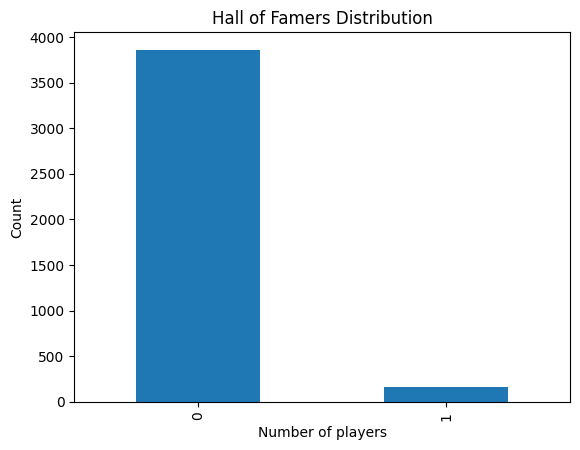

In [16]:
value_counts = former_df['HOF'].value_counts().sort_index()
value_counts.plot(kind='bar')
plt.title('Hall of Famers Distribution')
plt.xlabel('Number of players')
plt.ylabel('Count')
plt.show()

In [17]:
len(recent_df)

1001

We can see that, of the former NBA players, only 163 out of 4,022 are in the Hall of Fame, about 4%. Since there are 1,001 current and recent players, we should expect about 40 of them to become Hall of Famers.

In [18]:
former_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4022 entries, 0 to 5022
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Player             4022 non-null   object 
 1   From               4022 non-null   int64  
 2   To                 4022 non-null   int64  
 3   Years              4022 non-null   int64  
 4   Pos                4022 non-null   object 
 5   Ht                 4022 non-null   object 
 6   Height             3775 non-null   float64
 7   Wt                 3786 non-null   float64
 8   G                  3791 non-null   float64
 9   PTS                4022 non-null   float64
 10  TRB                4022 non-null   float64
 11  AST                4022 non-null   float64
 12  FG%                3773 non-null   float64
 13  FG3%               4022 non-null   float64
 14  FT%                4022 non-null   float64
 15  eFG%               4022 non-null   float64
 16  PER                4022 non-n

Let us look at a few of this HOF players and check out which features are correlated with being an Hall of Famer.

Now that we explored the data a bit, the final thing to do is to reset the index for the current/recent and former player datasets.

In [19]:
recent_df.reset_index(drop=True, inplace=True)

In [20]:
former_df.reset_index(drop=True, inplace=True)

Finally, let's save all 3 of the datasets to csv files to use for data exploration and analysis.

In [ ]:
players_df.to_csv('input_data/NBA_players_full.csv', index=False)
former_df.to_csv('input_data/former_players.csv', index=False)
recent_df.to_csv('input_data/recent_players.csv', index=False)

In [ ]:
players_df = pd.read_csv('input_data/NBA_players_full.csv')
former_df = pd.read_csv('input_data/former_players.csv')
recent_df = pd.read_csv('input_data/recent_players.csv')

In [21]:
former_df.head()

,Player,From,To,Years,Pos,Ht,Height,Wt,G,PTS,...,DPOY,ROY,AS MVP,CF MVP,Finals MVP,MVP,Championships,NBA 75 Team,ABA All-Time Team,HOF
0,Alaa Abdelnaby,1991,1995,5,F-C,6-10,6.833333,240.0,256.0,5.7,...,0,0,0,0,0.0,0.0,0,0,0,0
1,Zaid Abdul-Aziz,1969,1978,10,F-C,6-9,6.750000,235.0,505.0,9.0,...,0,0,0,0,0.0,0.0,0,0,0,0
2,Kareem Abdul-Jabbar*,1970,1989,20,C,7-2,7.166667,225.0,1560.0,24.6,...,0,1,0,0,2.0,6.0,6,1,0,1
3,Mahmoud Abdul-Rauf,1991,2001,11,G,6-1,6.083333,162.0,586.0,14.6,...,0,0,0,0,0.0,0.0,0,0,0,0
4,Tariq Abdul-Wahad,1998,2003,6,F,6-6,6.500000,NaN,NaN,7.8,...,0,0,0,0,NaN,NaN,0,0,0,0


The starting dataset was very clean.

In [22]:
former_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4022 entries, 0 to 4021
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Player             4022 non-null   object 
 1   From               4022 non-null   int64  
 2   To                 4022 non-null   int64  
 3   Years              4022 non-null   int64  
 4   Pos                4022 non-null   object 
 5   Ht                 4022 non-null   object 
 6   Height             3775 non-null   float64
 7   Wt                 3786 non-null   float64
 8   G                  3791 non-null   float64
 9   PTS                4022 non-null   float64
 10  TRB                4022 non-null   float64
 11  AST                4022 non-null   float64
 12  FG%                3773 non-null   float64
 13  FG3%               4022 non-null   float64
 14  FT%                4022 non-null   float64
 15  eFG%               4022 non-null   float64
 16  PER                4022 

With a quick look, we see that most of the data is numerical, and does not need any particular transformation.
The only categorical columns are the Player column, which represents the name of the player, and the Pos column that represents the position of a certain player, and the Ht column which represents the height of a player (we see the numerical value for it in the Height column).

The Player column will obviously not be used for the scope of this evaluation. On the other hand, we can take care of the Pos column with One Hot Encoding.

Before doing that, let's try to understand the correlation between different features of our feature matrix with our target column, HOF.

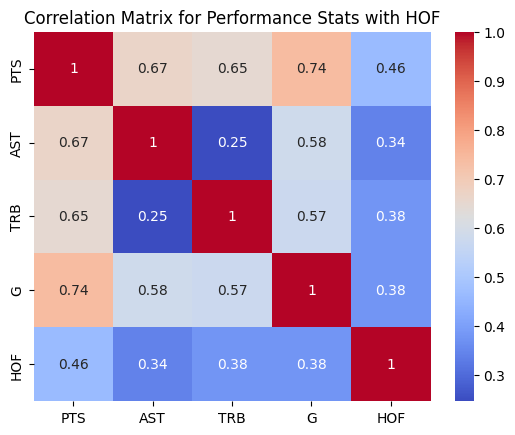

In [23]:
performance_stats = ['PTS', 'AST', 'TRB', 'G', 'HOF']

# Note PTS stands for Points, AST for Assists, TRB for Total Rebound Percentage, and G for Games played.

corr_performance_stats = former_df[performance_stats].corr()

sns.heatmap(corr_performance_stats, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Performance Stats with HOF')
plt.show()

Out of all the performance stats, the things that are the most correlated are points, but the other performance stats also show some correlation.

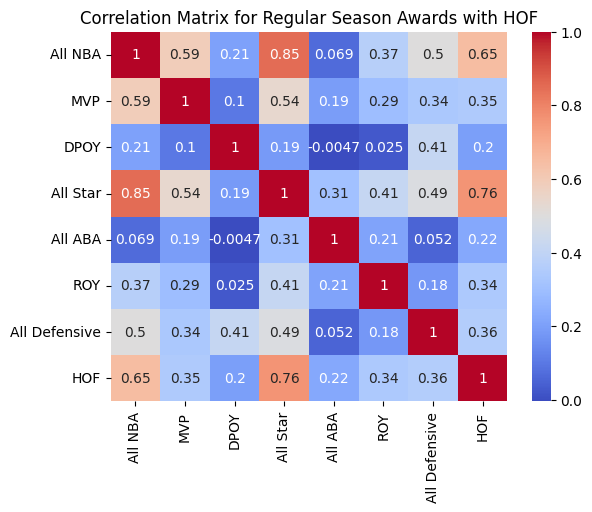

In [24]:
awards_honors = ['All NBA', 'MVP', 'DPOY', 'All Star', 'All ABA', 'ROY', 'All Defensive', 'HOF']
corr_awards_honors = former_df[awards_honors].corr()

sns.heatmap(corr_awards_honors, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Regular Season Awards with HOF')
plt.show()

We can clearly see that All Star Game appearances and All NBA teams are highly correlated with being hall of famers. Surprisingly, being the Most Valuable Player is not as important. Finally, being a great defensive player in the league does not have much of a correlation with being a Hall of Famer.

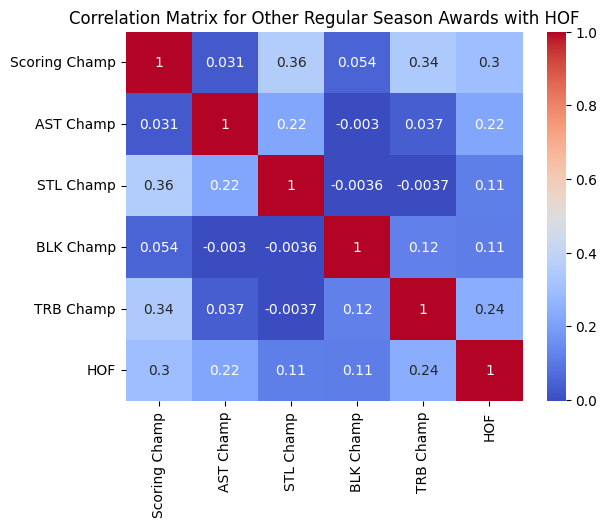

In [25]:
leadership_impact = ['Scoring Champ', 'AST Champ', 'STL Champ', 'BLK Champ', 'TRB Champ', 'HOF']
corr_leadership_impact = former_df[leadership_impact].corr()

sns.heatmap(corr_leadership_impact, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Other Regular Season Awards with HOF')
plt.show()

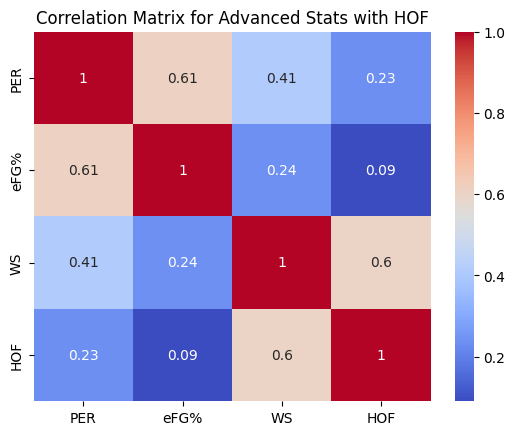

In [26]:
advanced_stats = ['PER', 'eFG%', 'WS', 'HOF']
corr_advanced_stats = former_df[advanced_stats].corr()

sns.heatmap(corr_advanced_stats, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Advanced Stats with HOF')
plt.show()

These advanced statistics show the impact a player has on winning. We see that winning is considered very important and highly correlated with players being Hall of Famers.

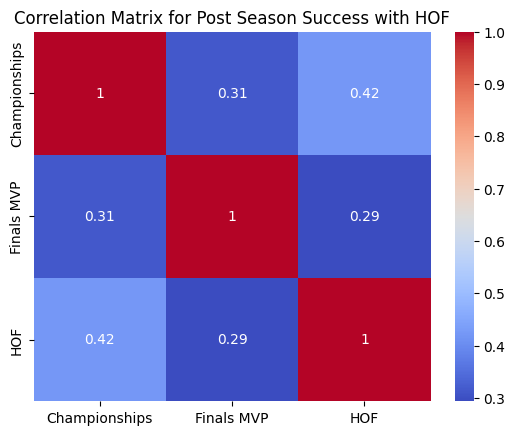

In [27]:
post_success = ['Championships', 'Finals MVP', 'HOF']
corr_post_success = former_df[post_success].corr()

sns.heatmap(corr_post_success, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Post Season Success with HOF')
plt.show()

We can see somewhat of a positive correlation between being a Hall of Famer and winning championships and getting Finals MVPs.

Let us define our Feature Matrix, i.e. the features we will use for the evaluation.

In [28]:
X = former_df[['Years', 'Height', 'Wt', 'Pos', 'G', 'PTS', 'TRB', 'AST', 'FG%', 'FG3%', 'FT%', 
               'eFG%', 'PER', 'WS', 'All Star', 'All NBA', 'All ABA', 'All Rookie', 
               'All Defensive', 'BLK Champ', 'STL Champ', 'TRB Champ', 'AST Champ', 
               'Scoring Champ', 'Most Improved', 'Sixth Man', 'DPOY', 'ROY', 'AS MVP', 
               'CF MVP', 'Finals MVP', 'MVP', 'Championships', 'NBA 75 Team', 'ABA All-Time Team']]

In [29]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4022 entries, 0 to 4021
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Years              4022 non-null   int64  
 1   Height             3775 non-null   float64
 2   Wt                 3786 non-null   float64
 3   Pos                4022 non-null   object 
 4   G                  3791 non-null   float64
 5   PTS                4022 non-null   float64
 6   TRB                4022 non-null   float64
 7   AST                4022 non-null   float64
 8   FG%                3773 non-null   float64
 9   FG3%               4022 non-null   float64
 10  FT%                4022 non-null   float64
 11  eFG%               4022 non-null   float64
 12  PER                4022 non-null   float64
 13  WS                 4022 non-null   float64
 14  All Star           4022 non-null   int64  
 15  All NBA            4022 non-null   int64  
 16  All ABA            3776 

Our data consisting of all the former players (retired for 4 or more years) has been created and includes the most important features for our evaluation. Now let us define transformers and a pipeline so we can transform the data correctly. Note that most of the features are numeric, and the only feature that is categorical is Pos, referring to the position of the player. We can take care of that with one hot encoding.

In [30]:
cat_features = ['Pos']

Let us create a ColumnTransformer so we can impute the missing values in the way we want to.
1. For the MVP, Finals MVP, Scoring Champ, All ABA we want to impute the most common value, which is 0.
2. Regarding the Games played (G), FG%, Ht, and Wt we will impute the mean value.

Furthermore, we need to handle our only categorical column, which is the 'Pos' column. We'll do that with OneHotEncoding, and we will scale the rest of the columns, which are all numerical, with a StandarScaler.

In [31]:
zero_impute_columns = ['MVP', 'Finals MVP', 'Scoring Champ', 'All ABA']
mean_impute_columns = ['G', 'FG%', 'Height', 'Wt']

In [32]:
zero_impute_scale_pipeline = IMBPipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

mean_impute_scale_pipeline = IMBPipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = IMBPipeline(steps=[
    ('onehot', OneHotEncoder())
])

In [33]:
num_features = [i for i in [i for i in X.select_dtypes(include=['int64', 'float64']).columns.tolist() if i not in zero_impute_columns] if i not in mean_impute_columns]

In [34]:
num_features

['Years',
 'PTS',
 'TRB',
 'AST',
 'FG3%',
 'FT%',
 'eFG%',
 'PER',
 'WS',
 'All Star',
 'All NBA',
 'All Rookie',
 'All Defensive',
 'BLK Champ',
 'STL Champ',
 'TRB Champ',
 'AST Champ',
 'Most Improved',
 'Sixth Man',
 'DPOY',
 'ROY',
 'AS MVP',
 'CF MVP',
 'Championships',
 'NBA 75 Team',
 'ABA All-Time Team']

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ('zero_impute_scale', zero_impute_scale_pipeline, zero_impute_columns),
        ('mean_impute_scale', mean_impute_scale_pipeline, mean_impute_columns),
        ('cat', categorical_pipeline, cat_features),
        ('scale', StandardScaler(), num_features)
    ]
)

In [36]:
preprocessor

ColumnTransformer(transformers=[('zero_impute_scale',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('scaler', StandardScaler())]),
                                 ['MVP', 'Finals MVP', 'Scoring Champ',
                                  'All ABA']),
                                ('mean_impute_scale',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['G', 'FG%', 'Height', 'Wt']),
                                ('cat',
                                 Pipeline(steps=[('onehot', OneHotEncoder())]),
                                 ['Pos']),
                                ('scale', StandardScaler(),
                                 ['Years', 'PTS', 'TRB', 'AST', 'FG3%', 'FT%',
                                  'eFG%', 'PER', 'WS', 'All Star', 'All NBA',
                                  'All Rookie', 'All Defensive', 'BLK Champ',
                                  'STL Champ', 'TRB Champ', 'AST Champ',
                                  'Most Improved', 'Sixth Man', 'DPOY', 'ROY',
                                  'AS MVP', 'CF MVP', 'Championships',
                                  'NBA 75 Team', 'ABA All-Time Team'])])

In [37]:
pip = IMBPipeline([
    ('prep', preprocessor),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', Perceptron())
])

In [38]:
Y = former_df['HOF']

In [39]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

## Models Selection

Let's start by checking different model and analizing their performance.

We will try a few different models and configurations:
- For Sampling, we'll try to use SMOTE (Synthetic Minority Over-sampling Technique) and a RandomOverSampler.
- For Dimensionality Reduction we will try to use PCA, LDA and SequentialFeatureSelector that uses Perceptron or LogisticRegression as estimators.
- For classifiers, we'll try different configurations of LogisticRegression, Perceptron, KNeighbors, SVC, and finally RandomForest, and XGBoost (gradient boosting).

In [40]:
sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10,13,15,20,25]
    }
]

classifier_configs = [
    {
        'classifier__eta0' : loguniform(0.001,100),
        'classifier': [Perceptron()] ,
        'classifier__max_iter': [1,5,10,15,50,100] ,
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__C' : loguniform(1e-2, 1e1),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [1,3,5,7,9]
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [10, 25, 50, 100, 125]
    },
    {
        'classifier': [SVC()],
        'classifier__C': loguniform(1e-2, 1e1),
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__gamma': loguniform(1e-4, 1),
        'classifier__class_weight': [None, 'balanced'],
    },
    {
    'classifier': [XGBClassifier(use_label_encoder=False, eval_metric='logloss')],
    'classifier__n_estimators': [100, 150, 200, 250, 300],
    'classifier__learning_rate': loguniform(0.01, 0.03),
    'classifier__max_depth': [3, 6, 9],
    'classifier__subsample': [0.7, 0.8, 1.0]
    }

]

In [41]:
all_configs = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    # Merging of three dictionary into one
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs.append(dict(all_parameters)) # by dict(all_parameters) we create a dict from a list of pairs (key:value)

In [42]:
len(all_configs)

72

In [43]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    rs = RandomizedSearchCV(
        pip,
        param_distributions=all_configs,  # This should be a dictionary of distributions
        n_iter=len(all_configs)*10,  # At least 10 times the number of configurations
        cv=5,
        scoring='f1',
        verbose=1,
        random_state=42
    )

    # Perform cross-validation on the RandomizedSearchCV object
    scores = cross_validate(
        rs,
        x_train,
        y_train,
        scoring='f1',
        cv=5,
        return_estimator=True,
        verbose=3
    )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV] END ......................................., score=0.923 total time=28.8min
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 28.8min remaining:    0.0s


[CV] END ......................................., score=0.667 total time=27.7min
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 56.5min remaining:    0.0s


[CV] END ......................................., score=0.718 total time=29.7min
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV] END ......................................., score=0.756 total time=26.8min
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV] END ......................................., score=0.880 total time=26.7min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 139.7min finished


In [44]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
SequentialFeatureSelector(cv=None, estimator=Perceptron(), k_features=(15, 15),
                          scoring='f1')
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.025925059608572082, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': Non

In [45]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(x_train, y_train)
    pred_train = estimator.best_estimator_.predict(x_train)
    pred_test = estimator.best_estimator_.predict(x_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.8658008658008659, F1 on test set:0.8055555555555555
F1 on training set:1.0, F1 on test set:0.8437500000000001
F1 on training set:0.6798029556650247, F1 on test set:0.6785714285714285
F1 on training set:0.8290598290598291, F1 on test set:0.8484848484848486
F1 on training set:1.0, F1 on test set:0.8437500000000001


The best models seem to be RandomForestClassifier and XGBoost. We see that the RandomForest tends to overfit on the training data, as we can see from its relatively low performance on the test set compared to the training set.
Now we'll do a more exhaustive search only focusing on these two models, adding more parameters to see which of these two is better so we can do a more deep hyperparameter optimization.

In [46]:
sampler_configs = [
    {
        'sampler':[None], 
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron()],
        'dim_reduction__k_features' : [5,7,10,13,15,20,25]
    }
]

classifier_configs = [
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__max_depth': [None, 10, 15, 20],
        'classifier__min_samples_split': [2, 4, 6, 10],
        'classifier__min_samples_leaf': [1, 2, 4, 6]
    },
    {
    'classifier': [XGBClassifier(use_label_encoder=False, eval_metric='logloss')],
    'classifier__n_estimators': [100, 150, 200, 250, 300],
    'classifier__learning_rate': loguniform(0.01, 0.03),
    'classifier__max_depth': [3, 6, 9],
    'classifier__subsample': [0.7, 0.8, 1.0]
    }
]

In [47]:
all_configs1 = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs1.append(dict(all_parameters))

In [48]:
rs1 = RandomizedSearchCV(
    pip,
    param_distributions=all_configs1,
    n_iter=len(all_configs1)*10,
    cv=5,
    scoring='f1',
    verbose=1,
    random_state=15
)

# Perform cross-validation on the RandomizedSearchCV object
scores1 = cross_validate(
    rs1,
    x_train,
    y_train,
    scoring='f1',
    cv=5,
    return_estimator=True,
    verbose=3
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END ......................................., score=0.863 total time=12.2min
Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.2min remaining:    0.0s


[CV] END ......................................., score=0.708 total time=11.9min
Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 24.2min remaining:    0.0s


[CV] END ......................................., score=0.750 total time=12.3min
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END ......................................., score=0.783 total time=12.3min
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END ......................................., score=0.824 total time=13.2min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 61.9min finished


In [49]:
for index, estimator in enumerate(scores1['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
SequentialFeatureSelector(cv=None, estimator=LogisticRegression(),
                          k_features=(13, 13), scoring='f1')
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.020776830970651767, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbac

In [51]:
for estimator in scores1['estimator']:
    pred_train = estimator.best_estimator_.fit(x_train, y_train)
    pred_train = estimator.best_estimator_.predict(x_train)
    pred_test = estimator.best_estimator_.predict(x_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.8311688311688312, F1 on test set:0.8125
F1 on training set:0.9243697478991597, F1 on test set:0.8115942028985507
F1 on training set:0.8927038626609443, F1 on test set:0.8307692307692307
F1 on training set:0.8831168831168831, F1 on test set:0.8059701492537314
F1 on training set:0.8484848484848485, F1 on test set:0.8125


We see that the models seems to have an overall good performance both on the training and testing data, even though we see a bit of overfitting from a couple of these models, which we will take care of. 
Going forward, there is not a clear favorite to which model should be used, but I will go on exploring the potential of the XGBClassifier, as it is known as a versatile model that performs extremely well for a wide range of tasks. 

We will now try to perform hyperparameter optimization for the XGBClassifier.

## Hyperparameter Optimization

Now that we chose the XGBClassifier as a model, let us try to optimize the parameters to get the best prediction possible. In order to do that, we will run a RandomizedSearch to narrow down the range of parameters and configurations and get a better idea, then I will run a more focused GridSearchCV to get the best possible model.

Based on the results of the previous models, I created a more focused range for RandomizedSearchCV to better understand where to focus.

In [52]:
best_pip = IMBPipeline([
    ('prep', preprocessor),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA()),
    ('classifier', XGBClassifier())
])

In [53]:
sampler_configs = [
    {'sampler': [None]},
    {'sampler': [SMOTE()], 'sampler__sampling_strategy': ['minority', 0.7, 0.9, 1.2]},
    {'sampler': [RandomOverSampler()], 'sampler__sampling_strategy': ['minority', 0.7, 0.9, 1.2]}
]

dim_reduction_configs = [
    {'dim_reduction': [None]},  # Baseline: no dimensionality reduction
    {'dim_reduction': [PCA()], 'dim_reduction__n_components': [0.6, 0.7, 0.8]},
    {'dim_reduction': [LDA()]},
    {'dim_reduction': [SFS(estimator=LogisticRegression(), cv=None, scoring='f1')],
     'dim_reduction__estimator': [LogisticRegression()],
     'dim_reduction__k_features': [8, 10, 12]
    }
]
classifier_configs = [
    {
        'classifier': [XGBClassifier(use_label_encoder=False, eval_metric='logloss')],
        'classifier__n_estimators': [125, 150, 175, 200, 225, 250],
        'classifier__learning_rate': [0.02, 0.022, 0.024, 0.026, 0.028],
        'classifier__max_depth': [5, 6, 7, 8, 9, 10],
        'classifier__subsample': [0.6, 0.65, 0.7, 0.75, 0.8],
        'classifier__scale_pos_weight': [1, 10, 20, 30],
        'classifier__min_child_weight': [1, 2, 3, 4, 5],
        'classifier__gamma': [0, 0.1, 0.2, 0.3, 0.4]
    }
]

In [54]:
all_configs2 = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    # Merging of three dictionary into one
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs2.append(dict(all_parameters)) # by dict(all_parameters) we create a dict from a list of pairs (key:value)

In [55]:
len(all_configs2)

12

In [56]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # Ignore all warnings
    
    # Define and fit the RandomizedSearchCV object inside the block
    rs2 = RandomizedSearchCV(
        best_pip,
        param_distributions=all_configs2,
        n_iter=len(all_configs2) * 30,
        n_jobs=-1,
        cv=5,
        scoring='f1'
    )
    
    # Perform the cross-validation inside the block as well
    scores2 = cross_validate(
        rs2,
        x_train,
        y_train,
        scoring='f1',
        cv=5,
        return_estimator=True,
        verbose=3
    )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ......................................., score=0.863 total time= 2.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


[CV] END ......................................., score=0.708 total time= 2.5min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.2min remaining:    0.0s


[CV] END ......................................., score=0.810 total time= 3.3min
[CV] END ......................................., score=0.727 total time= 2.8min
[CV] END ......................................., score=0.840 total time= 3.1min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 14.3min finished


In [57]:
for index, estimator in enumerate(scores2['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
SequentialFeatureSelector(cv=None, estimator=LogisticRegression(),
                          k_features=(12, 12), scoring='f1')
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.026, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...) {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': N

In [58]:
for estimator in scores2['estimator']:
    pred_train = estimator.best_estimator_.fit(x_train, y_train)
    pred_train = estimator.best_estimator_.predict(x_train)
    pred_test = estimator.best_estimator_.predict(x_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.8412017167381974, F1 on test set:0.8125
F1 on training set:0.8583690987124463, F1 on test set:0.8358208955223881
F1 on training set:0.9808429118773946, F1 on test set:0.7733333333333333
F1 on training set:0.811965811965812, F1 on test set:0.7761194029850748
F1 on training set:0.8034188034188035, F1 on test set:0.8059701492537314


After this, I will create another list of parameters to narrow them down once more, until I can run a fully comprehensive GridSearchCV.

We can observe:
- The SequentialFeatureSelector seems to be improving the performance of some of these models. We will keep it to further test the need for dimensionality reduction.
- The model seems to work best without needing for sampling. I will try to include the RandomOverSampler as it appeared in one of the models for testing purposes.
- The depth of the tree seems to work well in the range of 6-10. We will explore this further.
- I will maintain a moderate learning rate, approximately between 0.2 and 0.3.
- From the previous model we see varying values of min_child_weight, so I will explore this ranges further.
- The parameter scale_pos_weight is equal to 1 in all but one of the models. We can set this parameter to 1 in our next evaluation.
- The subsample values found in the search were between the range [0.6, 0.7], hence we will explore this range further.
- The number of estimators varies greatly, we will keep exploring all combinations.
- gamma stays between 0 and 0.4, we will keep exploring this range.

In [60]:
sampler_configs = [
    {'sampler': [None]},
    {'sampler': [RandomOverSampler()], 'sampler__sampling_strategy': ['minority', 0.7, 0.9, 1.2]}
]

dim_reduction_configs = [
    {'dim_reduction': [None]},
    {'dim_reduction': [SFS(estimator=LogisticRegression(max_iter=1000), 
                           cv=None, 
                           scoring='f1')],
     'dim_reduction__estimator': [LogisticRegression(max_iter=1000)],
     'dim_reduction__k_features': [(10, 'parsimonious'), 
                                   (15, 'parsimonious'), 
                                   (20, 'parsimonious'), 
                                   'best', 
                                   'all']
    }
]


classifier_configs = [
    {
        'classifier': [XGBClassifier(use_label_encoder=False, eval_metric='logloss')],
        'classifier__n_estimators': [125, 150, 175, 200, 225, 250],
        'classifier__learning_rate': [0.02, 0.022, 0.024, 0.026, 0.028, 0.03],
        'classifier__max_depth': [5, 6, 7, 8, 9, 10],
        'classifier__subsample': [0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75, 0.8],
        'classifier__scale_pos_weight': [1],
        'classifier__min_child_weight': [1, 2, 3, 4, 5],
        'classifier__gamma': [0, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4]
    }
]

In [61]:
all_configs3 = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    # Merging of three dictionary into one
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs3.append(dict(all_parameters)) # by dict(all_parameters) we create a dict from a list of pairs (key:value)

In [62]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # Ignore all warnings
    
    rs3 = RandomizedSearchCV(
        best_pip,
        param_distributions=all_configs3,
        n_iter=len(all_configs3) * 30,
        n_jobs=-1,
        cv=5,
        scoring='f1'
    )
    
    scores3 = cross_validate(
        rs3,
        x_train,
        y_train,
        scoring='f1',
        cv=5,
        return_estimator=True,
        verbose=3
    )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ......................................., score=0.880 total time= 1.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] END ......................................., score=0.708 total time=  51.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


[CV] END ......................................., score=0.780 total time= 1.5min
[CV] END ......................................., score=0.783 total time= 1.9min
[CV] END ......................................., score=0.816 total time= 1.4min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.0min finished


In [63]:
for index, estimator in enumerate(scores3['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
None
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.35, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.024, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...) {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorica

In [64]:
for estimator in scores3['estimator']:
    pred_train = estimator.best_estimator_.fit(x_train, y_train)
    pred_train = estimator.best_estimator_.predict(x_train)
    pred_test = estimator.best_estimator_.predict(x_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.8547008547008547, F1 on test set:0.823529411764706
F1 on training set:0.8571428571428572, F1 on test set:0.8358208955223881
F1 on training set:0.9808429118773946, F1 on test set:0.7466666666666666
F1 on training set:0.8376068376068376, F1 on test set:0.8059701492537314
F1 on training set:0.8270042194092828, F1 on test set:0.823529411764706


After this, we found three models in particular that are working particularly well. Let us analyze these models, while also taking into consideration something from the models that performed slightly worse.
- Starting off, the best models were ones that did not use any dimensionality reduction techniques. Even if that is the case, SequentialFeatureSelection with LogisticRegression showed some promise, so we will keep it simply with the 'all' parameter.
- The two best-performing models had respectively max_depth set to 6 and 9. Values in the range are also observed in the other models, so we will keep exploring this range.
- The models seem to perform better with a learning rate between 0,22 and 0,26. We will explore this range thoroughly.
- The best models have varying values of estimators. We will keep testing different values.
- The value of gamma varied a lot within these models.
- The value of min_child_weight is consistently either 2 or 3. We will only test these values going forward.
- We will reduce the subsample range to [0.6, 0.8].
- We will remove sampling as it does not seem to be very beneficial to our model.

In [67]:
sampler_configs = [
    {'sampler': [None]},
    {'sampler': [RandomOverSampler()], 'sampler__sampling_strategy': ['minority']}
]

dim_reduction_configs = [
    {'dim_reduction': [None]},
    {'dim_reduction': [SFS(estimator=LogisticRegression(max_iter=1000), 
                           cv=None, 
                           scoring='f1')],
     'dim_reduction__estimator': [LogisticRegression(max_iter=1000)],
     'dim_reduction__k_features': ['best', 
                                   'all']
    }
]


classifier_configs = [
    {
        'classifier': [XGBClassifier(use_label_encoder=False, eval_metric='logloss')],
        'classifier__n_estimators': [170, 175, 180, 185, 190, 195, 200, 225, 250],
        'classifier__learning_rate': [0.02, 0.021, 0.0215, 0.022, 0.023, 0.024, 0.0245, 0.025, 0.0255, 0.026, 0.028, 0.03],
        'classifier__max_depth': [5, 6, 7, 8, 9],
        'classifier__subsample': [0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75],
        'classifier__scale_pos_weight': [1],
        'classifier__min_child_weight': [2, 3],
        'classifier__gamma': [0.1, 0.2, 0.25, 0.3, 0.35, 0.4]
    }
]

In [68]:
all_configs4 = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs4.append(dict(all_parameters))

In [69]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    rs4 = RandomizedSearchCV(
        best_pip,
        param_distributions=all_configs4,
        n_iter=len(all_configs4) * 30,
        n_jobs=-1,
        cv=5,
        scoring='f1'
    )
    
    # Perform the cross-validation inside the block as well
    scores4 = cross_validate(
        rs4,
        x_train,
        y_train,
        scoring='f1',
        cv=5,
        return_estimator=True,
        verbose=3
    )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ......................................., score=0.880 total time= 2.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


[CV] END ......................................., score=0.681 total time= 2.5min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.2min remaining:    0.0s


[CV] END ......................................., score=0.780 total time= 4.1min
[CV] END ......................................., score=0.783 total time= 3.0min
[CV] END ......................................., score=0.840 total time= 3.1min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 15.4min finished


In [70]:
for index, estimator in enumerate(scores4['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
None
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.023, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=195,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...) {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical

In [71]:
for estimator in scores4['estimator']:
    pred_train = estimator.best_estimator_.fit(x_train, y_train)
    pred_train = estimator.best_estimator_.predict(x_train)
    pred_test = estimator.best_estimator_.predict(x_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.876595744680851, F1 on test set:0.8358208955223881
F1 on training set:0.853448275862069, F1 on test set:0.8358208955223881
F1 on training set:0.8632478632478633, F1 on test set:0.8358208955223881
F1 on training set:0.8425531914893617, F1 on test set:0.8059701492537314
F1 on training set:0.8484848484848485, F1 on test set:0.823529411764706


These models show very good performance already. Let us try to analyze the best ones to narrow down the range of parameters and run a more comprehensive GridSearch.
- The learning rate parameter ranges between 0.021 and 0.028. We'll explore this range.
- The max_depth parameters ranges between 5-8 suggesting we need a moderate depth. We'll explore this range thoroughly.
- Gamma seems to stay in the interval [0.25, 0.35].
- n_estimators stays within the range [170, 200] favoring numbers towards the end of the interval.
- min_child_weight parameters stays between 2 and 3. We'll keep this value as is.
- Subsample takes values in the interval [0.6, 0.675]. We'll explore this further including some greater values.
- Dimensionality reduction or oversampling consistently do not seem to be beneficial to our model. We'll remove them from further evaluations.

In [72]:
sampler_configs = [
    {'sampler': [None]},
]

dim_reduction_configs = [
    {'dim_reduction': [None]},
]


classifier_configs = [
    {
        'classifier': [XGBClassifier(use_label_encoder=False, eval_metric='logloss')],
        'classifier__n_estimators': [170, 175, 180, 185, 190, 195, 200],
        'classifier__learning_rate': [0.02, 0.021, 0.0215, 0.022, 0.0225, 0.023, 0.0235, 0.024, 0.0245, 0.025, 0.0255, 0.026, 0.027, 0.028],
        'classifier__max_depth': [5, 6, 7, 8, 9],
        'classifier__subsample': [0.6, 0.625, 0.65, 0.675, 0.7],
        'classifier__scale_pos_weight': [1],
        'classifier__min_child_weight': [2, 3],
        'classifier__gamma': [0.2, 0.25, 0, 275, 0.3, 0,325, 0.35, 0.4]
    }
]

In [73]:
all_configs_gs = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs_gs.append(dict(all_parameters))

In [74]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    gs = GridSearchCV(
        best_pip,
        param_grid=all_configs_gs,
        n_jobs=-1,
        cv=5,
        scoring='f1'
    )
    
    # Perform the cross-validation inside the block as well
    scores_gs = cross_validate(
        gs,
        x_train,
        y_train,
        scoring='f1',
        cv=5,
        return_estimator=True,
        verbose=3
    )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ......................................., score=0.898 total time=38.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 38.3min remaining:    0.0s


[CV] END ......................................., score=0.708 total time=35.2min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 73.5min remaining:    0.0s


[CV] END ......................................., score=0.780 total time=38.4min
[CV] END ......................................., score=0.783 total time=37.3min
[CV] END ......................................., score=0.816 total time=38.7min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 187.9min finished


In [75]:
for index, estimator in enumerate(scores_gs['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
None
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...) {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': 

In [76]:
for estimator in scores_gs['estimator']:
    pred_train = estimator.best_estimator_.fit(x_train, y_train)
    pred_train = estimator.best_estimator_.predict(x_train)
    pred_test = estimator.best_estimator_.predict(x_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.8632478632478633, F1 on test set:0.8484848484848486
F1 on training set:0.8484848484848485, F1 on test set:0.8484848484848486
F1 on training set:0.8717948717948717, F1 on test set:0.8181818181818182
F1 on training set:0.8484848484848485, F1 on test set:0.8358208955223881
F1 on training set:0.853448275862069, F1 on test set:0.8358208955223881


The F1 score for 2/5 models is the same. We will choose the best one out of these 4 models by looking at the respective confusion matrix of each one of them to make the best decision possible. Then we will also take a look at the respective precision-recall curves and other metrics.

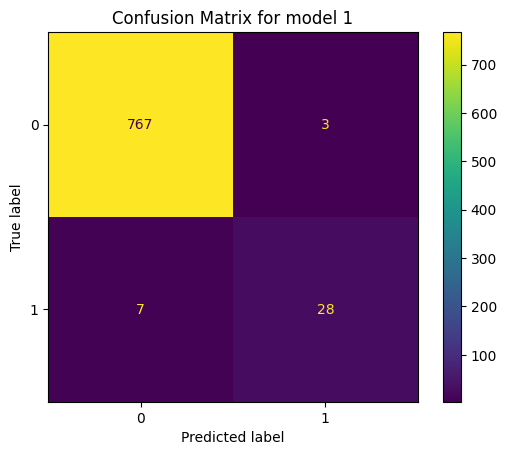

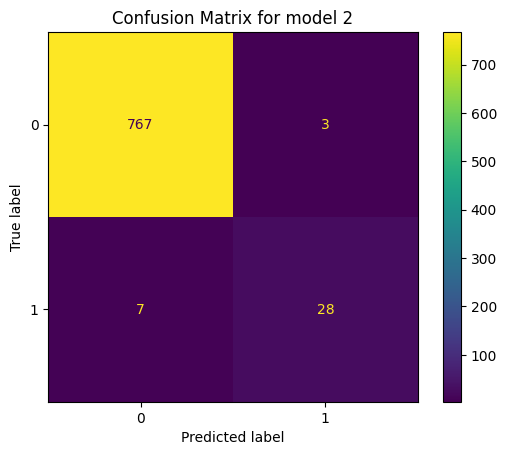

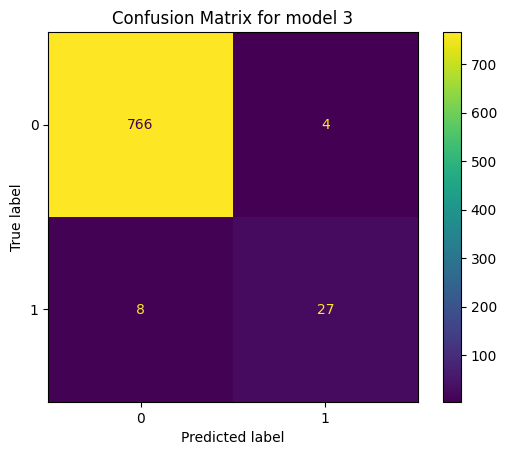

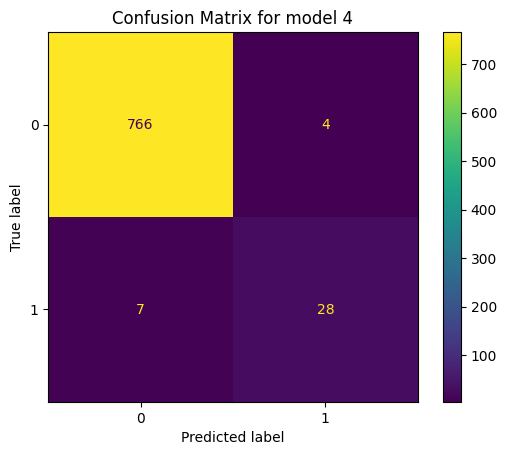

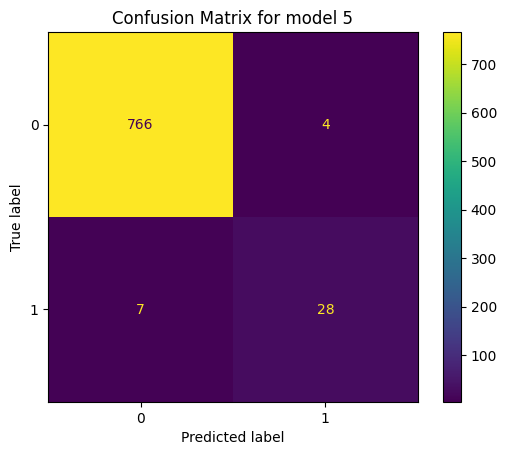

In [77]:
for index, estimator in enumerate(scores_gs['estimator']):
    best_model = estimator.best_estimator_
    best_model.fit(x_train, y_train)
    predictions = best_model.predict(x_test)
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for model {index+1}')
    plt.show()

The confusion matrixes for the best performing models are the exact same. Let us now look at their precision recall curves so we can choose the best out of these.

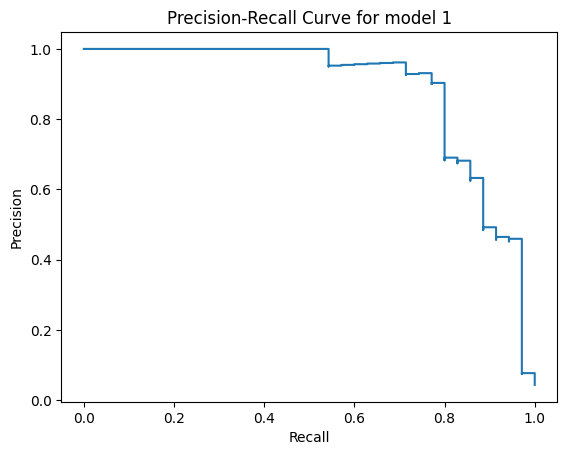

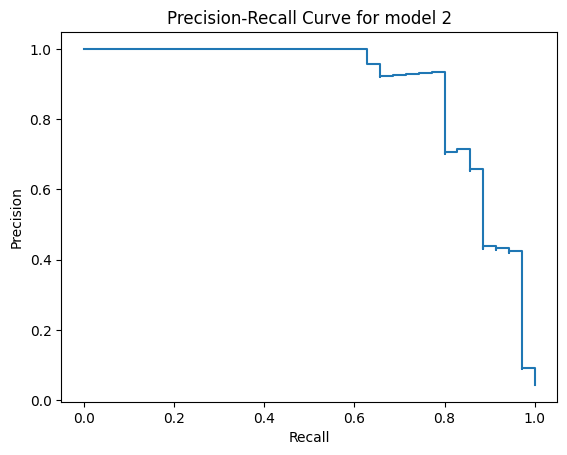

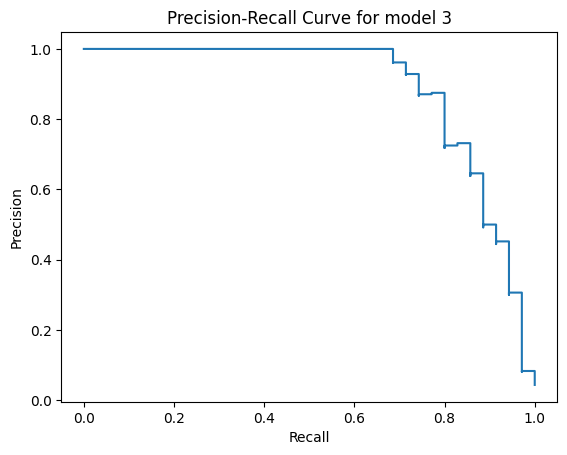

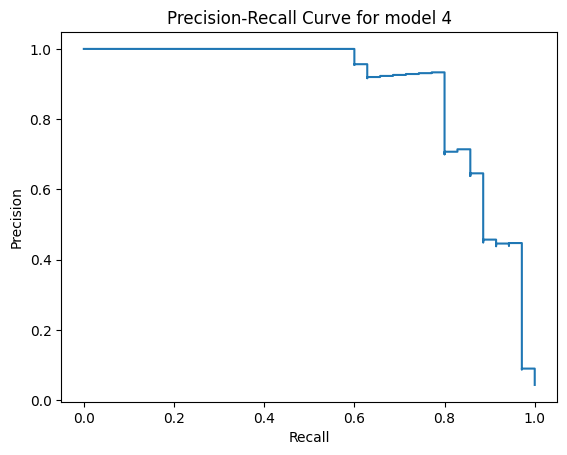

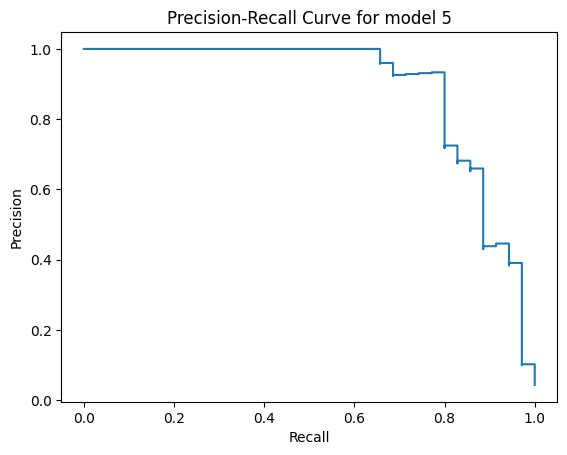

In [78]:
for index, estimator in enumerate(scores_gs['estimator']):
    best_model = estimator.best_estimator_
    best_model.fit(x_train, y_train)  # Fit the model on training data
    pred_probs = best_model.predict_proba(x_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, pred_probs)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title(f'Precision-Recall Curve for model {index+1}')
    plt.show()

In [79]:
average_precision_scores = []
for i, estimator in enumerate(scores_gs['estimator']):
    best_model = estimator.best_estimator_
    best_model.fit(x_train, y_train)
    pred_probs = best_model.predict_proba(x_test)[:, 1]
    average_precision = average_precision_score(y_test, pred_probs)
    average_precision_scores.append(average_precision)
    print(f'Model {i+1}: Average Precision = {average_precision}')


Model 1: Average Precision = 0.88584992821154
Model 2: Average Precision = 0.8877533616628828
Model 3: Average Precision = 0.8880032792915064
Model 4: Average Precision = 0.8864666134510574
Model 5: Average Precision = 0.8892201059945658


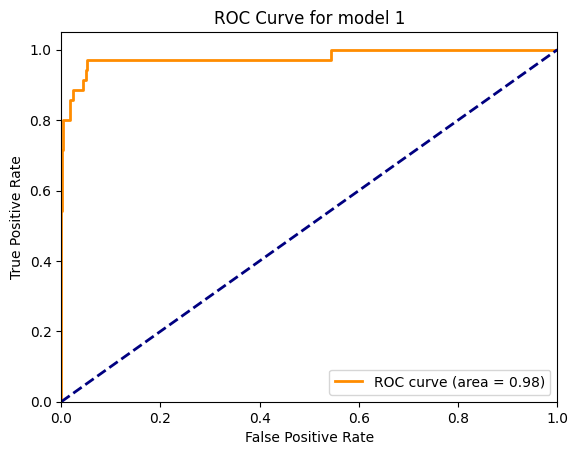

The AUC for model 1 is: 0.98


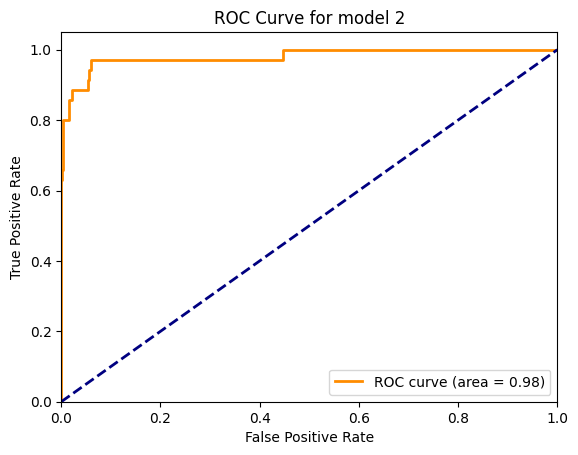

The AUC for model 2 is: 0.98


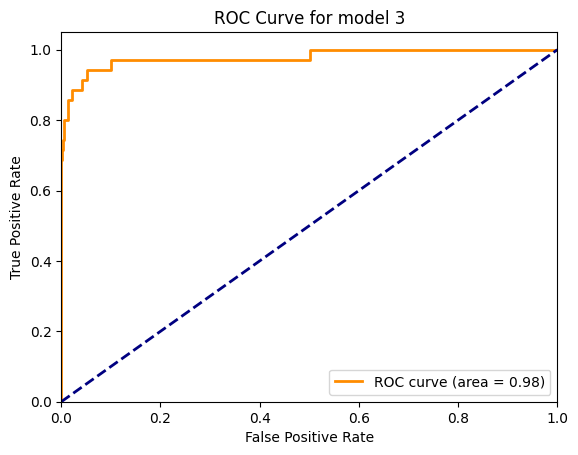

The AUC for model 3 is: 0.98


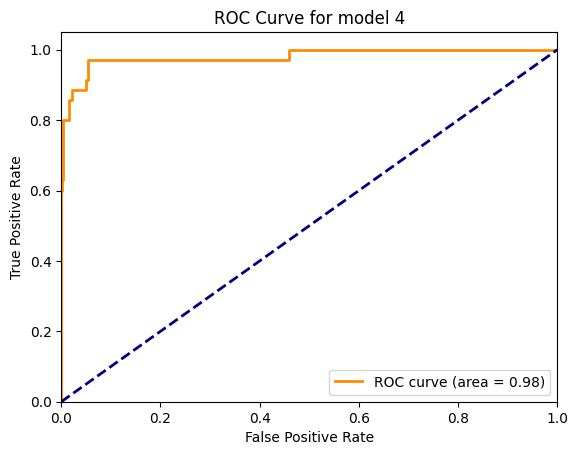

The AUC for model 4 is: 0.98


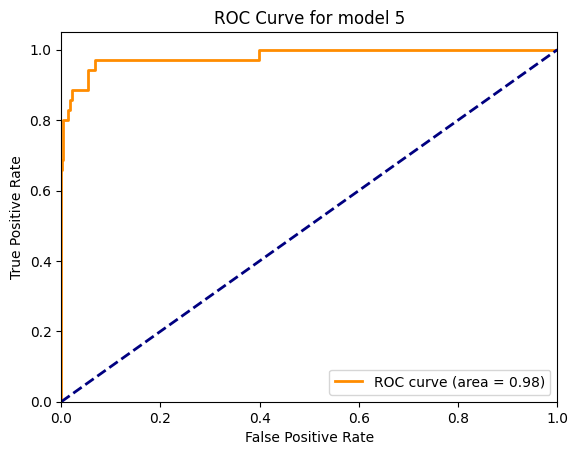

The AUC for model 5 is: 0.98


In [81]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

for index, estimator in enumerate(scores_gs['estimator']):
    best_model = estimator.best_estimator_
    best_model.fit(x_train, y_train)  # Fit the model on training data
    pred_probs = best_model.predict_proba(x_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, pred_probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for model {index+1}')
    plt.legend(loc="lower right")
    plt.show()

    print(f'The AUC for model {index+1} is: {roc_auc:.2f}')


We can see that these models have extremely similar performance according to different metrics.

The model I chose to go forward with is the second one, as it shows the best F1 score (tied with model 1), and shows very high performance according to the other metrics as well.

In [82]:
best_model = scores_gs['estimator'][3].best_estimator_

In [83]:
best_model['classifier'].get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': 0.2,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.02,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 6,
 'max_leaves': None,
 'min_child_weight': 2,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 170,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 1,
 'subsample': 0.7,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'use_label_encoder': False}

### Learning and Validation curve

Let us now refine the parameters further.

In [84]:
train_sizes, train_scores, test_scores = learning_curve(best_model,
                                                       X=x_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1',
                                                       shuffle = True)

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, in predict
    Xt = transform.transform(Xt)
  File "/opt/homebrew/lib/python3.1

(0.6, 1.03)

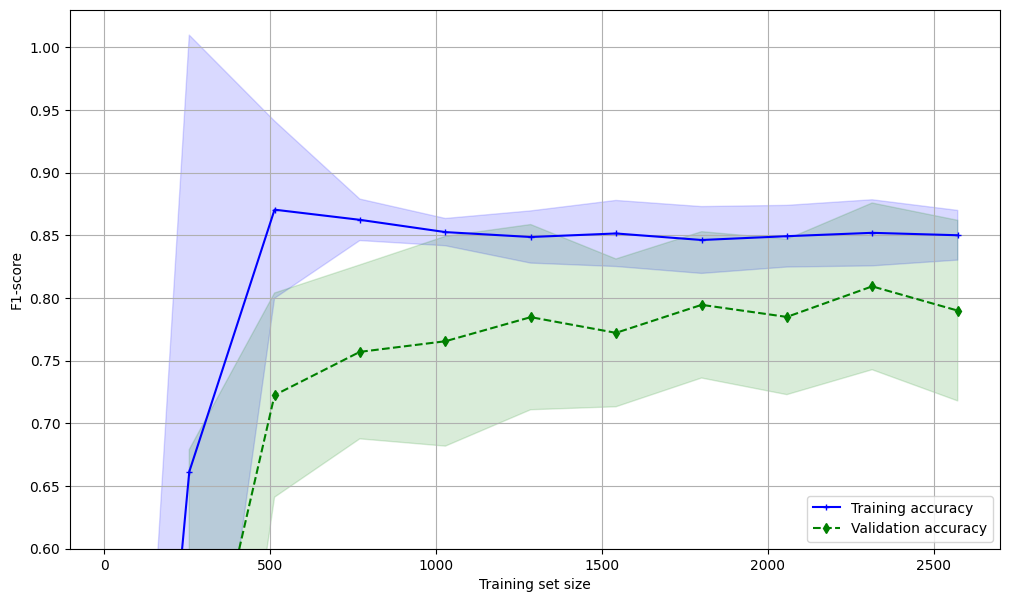

In [85]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.60, 1.03])

In [84]:
dump(model_4_pipeline, 'my_model.joblib')

['my_model.joblib']

In [85]:
dump(scores_gs, 'gs_scores.joblib')

['gs_scores.joblib']

In [19]:
model_4_pipeline = load('my_model.joblib')
scores_gs = load('gs_scores.joblib')

In [86]:
best_model['classifier'].get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': 0.2,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.02,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 6,
 'max_leaves': None,
 'min_child_weight': 2,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 170,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 1,
 'subsample': 0.7,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'use_label_encoder': False}

Even if we already narrowed down the range of parameters a lot, it may be beneficial to try and test it a bit further by creating a few validation curves for the different parameters.

In [88]:
range_learning_rate = [0.01, 0.015, 0.02, 0.0205, 0.021, 0.0215, 0.022, 0.0225, 0.023, 0.0235, 0.024, 0.0245, 0.025, 0.03, 0.04]
train_scores, test_scores = validation_curve(best_model,
        X=x_train, 
        y=y_train, 
        param_range=
        range_learning_rate, 
        param_name='classifier__learning_rate',
        cv=5, 
        n_jobs=-1, 
        scoring='f1'
)

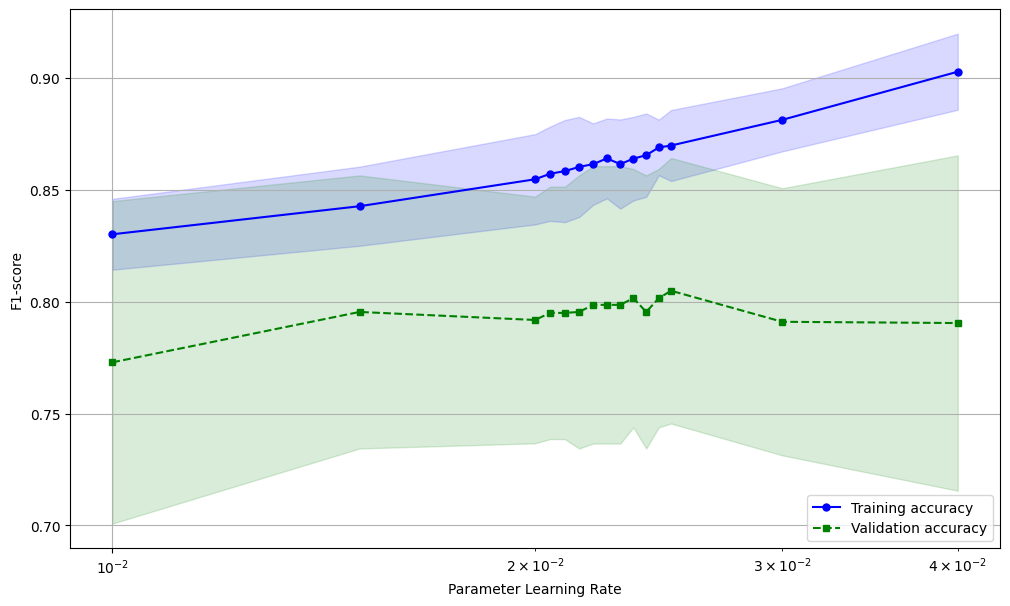

In [89]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_learning_rate, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_learning_rate,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_learning_rate, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_learning_rate,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter Learning Rate')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
# ax.set_ylim([0.6, 0.8])
ax.set_xscale('log')
# ax.set_xlim([0.05,100])

It seems that, as the learning rate increases, this leads to greater and greater overfitting. The parameter we had, which means a learning rate of 0.02 seems to be optimal, having a good F1-Score and seems to minimize standard deviation compared to the other parameters tested.

In [90]:
range_estimators = [150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225]
train_scores, test_scores = validation_curve(best_model,
        X=x_train, 
        y=y_train, 
        param_range=
        range_estimators, 
        param_name='classifier__n_estimators',
        cv=5, 
        n_jobs=-1, 
        scoring='f1'
)

([<matplotlib.axis.XTick at 0x2b06cb1c0>,
 [Text(150, 0, '150'),
  Text(155, 0, '155'),
  Text(160, 0, '160'),
  Text(165, 0, '165'),
  Text(170, 0, '170'),
  Text(175, 0, '175'),
  Text(180, 0, '180'),
  Text(185, 0, '185'),
  Text(190, 0, '190'),
  Text(195, 0, '195'),
  Text(200, 0, '200'),
  Text(205, 0, '205'),
  Text(210, 0, '210'),
  Text(215, 0, '215'),
  Text(220, 0, '220'),
  Text(225, 0, '225')])

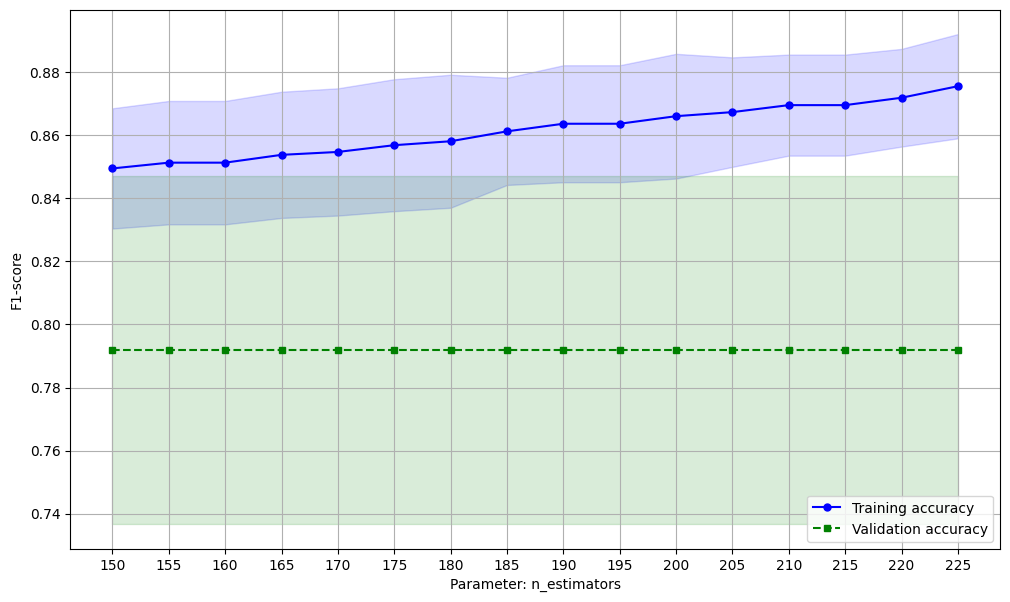

In [91]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_estimators, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_estimators,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_estimators, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_estimators,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter: n_estimators')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
# ax.set_ylim([0.6, 0.8])
plt.xticks(range_estimators)
# ax.set_xlim([0.05,100])

The validation accuracy is stable with varying values of the number of estimators. What we notice is the training accuracy becoming greater and greater with a bigger number of estimators, showing some overfitting as the number of estimators increase.

In [99]:
range_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
train_scores, test_scores = validation_curve(best_model,
        X=x_train, 
        y=y_train, 
        param_range=
        range_depth, 
        param_name='classifier__max_depth',
        cv=5, 
        n_jobs=-1, 
        scoring='f1'
)

([<matplotlib.axis.XTick at 0x2b09f29e0>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

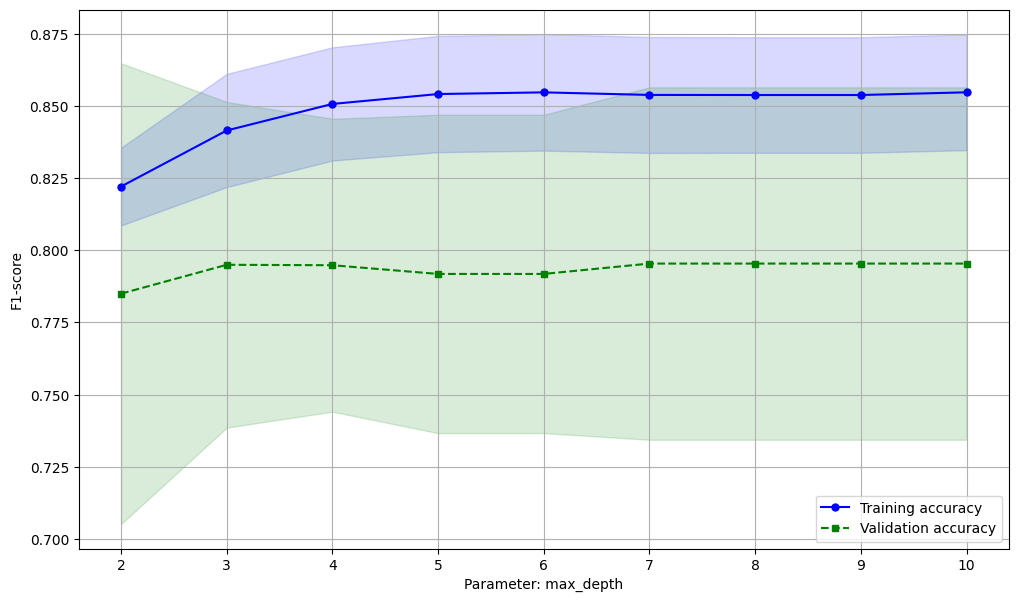

In [100]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_depth, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_depth,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_depth, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_depth,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter: max_depth')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
# ax.set_ylim([0.6, 0.8])
plt.xticks(range_depth)
# ax.set_xlim([0.05,100])

We see a good F1 score and minimal standard deviation for max_depth = 6.

In [104]:
range_subsample = [0.5, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75, 0.8, 0.9, 1]
train_scores, test_scores = validation_curve(best_model,
        X=x_train, 
        y=y_train, 
        param_range=
        range_subsample, 
        param_name='classifier__subsample',
        cv=5, 
        n_jobs=-1, 
        scoring='f1'
)

(0.5, 0.8)

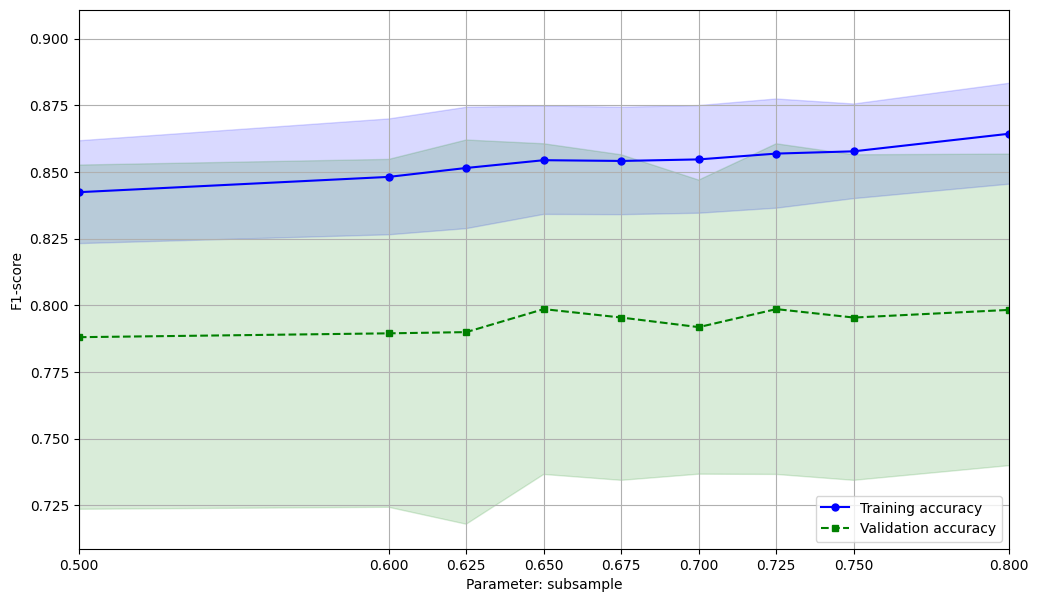

In [105]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_subsample, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_subsample,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_subsample, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_subsample,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter: subsample')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
# ax.set_ylim([0.6, 0.8])
plt.xticks(range_subsample)
ax.set_xlim([0.5,0.8])

The optimal value for the subsample is 0.7, then as the subsample increases, we see a slight increase in standard deviation and somewhat of a tendency to overfit on the training data.

Let us lastly check for the last parameter, gamma. This specifies the minimum reduction loss required to make a further partition on a leaf node of the tree. Generally, a greater value of gamma leads to a more conservative model.

In [107]:
range_gamma = [0, 0.1, 0.15, 0.2, 0.225, 0.25, 0.3, 0.35, 0.4, 0.5]
train_scores, test_scores = validation_curve(best_model,
        X=x_train, 
        y=y_train, 
        param_range=
        range_gamma, 
        param_name='classifier__gamma',
        cv=5, 
        n_jobs=-1, 
        scoring='f1'
)

(0.0, 0.5)

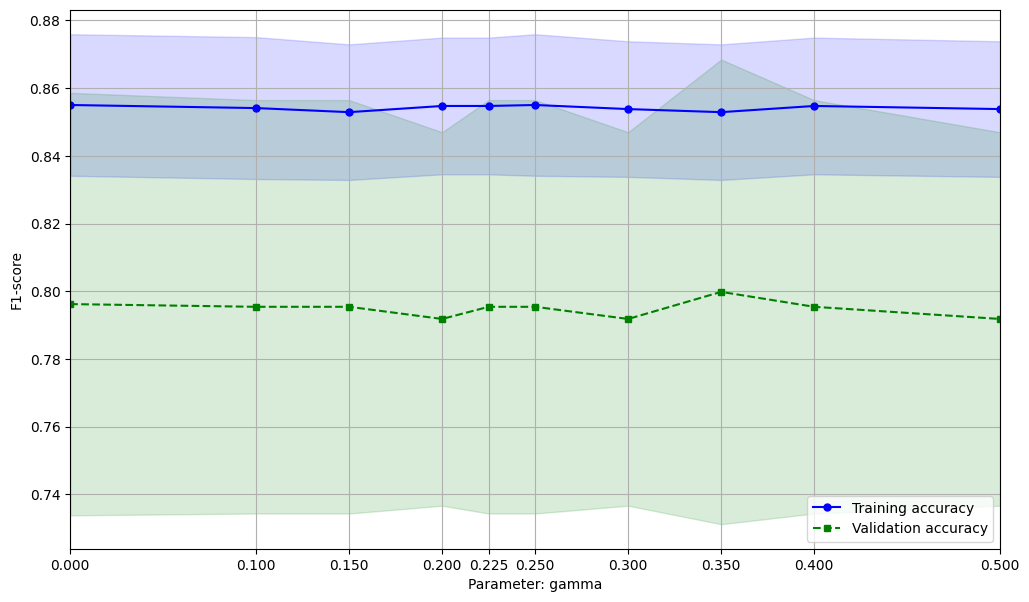

In [108]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_gamma, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_gamma,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_gamma, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_gamma,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter: gamma')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
# ax.set_ylim([0.6, 0.8])
plt.xticks(range_gamma)
ax.set_xlim([0,0.5])

The current value of gamma=0.2 seems optimal. Let us now show the final model and run our predictions for future hall of famers and try to understand how our model makes this predictions.

In [109]:
best_model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('zero_impute_scale',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MVP', 'Finals MVP',
                                                   'Scoring Champ',
                                                   'All ABA']),
                                                 ('mean_impute_scale',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['G', 'FG%', 'Height', 'Wt']),...
                               feature_types=None, gamma=0.2, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.02,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=2,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=170,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

## Predicting HOF Players on recent NBA players set

With our fine tuned model, we can now try to predict which players out of all the current players and recent players (i.e. their last season was not more than 4 years before 2022), which are going to end up being in the Hall of Fame. 

In [110]:
recent_X = recent_df[['Years', 'Height', 'Wt', 'Pos', 'G', 'PTS', 'TRB', 'AST', 'FG%', 'FG3%', 'FT%', 
               'eFG%', 'PER', 'WS', 'All Star', 'All NBA', 'All ABA', 'All Rookie', 
               'All Defensive', 'BLK Champ', 'STL Champ', 'TRB Champ', 'AST Champ', 
               'Scoring Champ', 'Most Improved', 'Sixth Man', 'DPOY', 'ROY', 'AS MVP', 
               'CF MVP', 'Finals MVP', 'MVP', 'Championships', 'NBA 75 Team', 'ABA All-Time Team']]

In [111]:
recent_pred = best_model.predict(recent_X)

In [112]:
recent_df['HOF'] = recent_pred

In [113]:
HOF_pred = recent_df[recent_df['HOF'] == 1]
HOF_pred

,Player,From,To,Years,Pos,Ht,Height,Wt,G,PTS,...,DPOY,ROY,AS MVP,CF MVP,Finals MVP,MVP,Championships,NBA 75 Team,ABA All-Time Team,HOF
11,LaMarcus Aldridge,2007,2022,16,F-C,6-11,6.916667,250.0,1076.0,19.1,...,0,0,0,0,0.0,0.0,0,0,0,1
26,Giannis Antetokounmpo,2014,2022,9,G-F,6-11,6.916667,NaN,656.0,21.8,...,1,0,1,0,NaN,2.0,1,1,0,1
29,Carmelo Anthony,2004,2022,19,F,6-7,6.583333,238.0,1260.0,22.5,...,0,0,0,0,0.0,0.0,0,1,0,1
144,Jimmy Butler,2012,2022,11,G-F,6-7,6.583333,230.0,690.0,17.7,...,0,0,0,0,0.0,0.0,0,0,0,1
158,Vince Carter,1999,2020,22,G-F,6-6,6.500000,220.0,1541.0,16.7,...,0,1,0,0,0.0,NaN,0,0,0,1
213,Stephen Curry,2010,2022,13,G,6-2,6.166667,185.0,826.0,24.3,...,0,0,1,1,1.0,NaN,4,1,0,1
216,Anthony Davis,2013,2022,10,F-C,6-10,6.833333,253.0,604.0,23.8,...,0,0,1,0,0.0,0.0,1,1,0,1
222,DeMar DeRozan,2010,2022,13,G-F,6-6,6.500000,220.0,957.0,20.8,...,0,0,0,0,0.0,0.0,0,0,0,1
254,Kevin Durant,2008,2022,15,G-F,6-10,6.833333,240.0,939.0,27.2,...,0,1,2,0,2.0,1.0,2,1,0,1
266,Joel Embiid,2017,2022,6,C,7-0,7.000000,280.0,328.0,26.0,...,0,0,0,0,0.0,0.0,0,0,0,1


We should note that the values are NaN because of the noise we added to the data at the start of the notebook.

Some players like Draymond Green or Andre Drummond will likely be hall of famers before the end of their career, but they were not recognized by the model as such. Now let us look at the feature importance of our classifier to better understand why that may be.

In [114]:
feature_names_after_preprocessing = best_model['prep'].get_feature_names_out()
feature_names_after_preprocessing

array(['zero_impute_scale__MVP', 'zero_impute_scale__Finals MVP',
       'zero_impute_scale__Scoring Champ', 'zero_impute_scale__All ABA',
       'mean_impute_scale__G', 'mean_impute_scale__FG%',
       'mean_impute_scale__Height', 'mean_impute_scale__Wt', 'cat__Pos_C',
       'cat__Pos_F', 'cat__Pos_F-C', 'cat__Pos_G', 'cat__Pos_G-F',
       'scale__Years', 'scale__PTS', 'scale__TRB', 'scale__AST',
       'scale__FG3%', 'scale__FT%', 'scale__eFG%', 'scale__PER',
       'scale__WS', 'scale__All Star', 'scale__All NBA',
       'scale__All Rookie', 'scale__All Defensive', 'scale__BLK Champ',
       'scale__STL Champ', 'scale__TRB Champ', 'scale__AST Champ',
       'scale__Most Improved', 'scale__Sixth Man', 'scale__DPOY',
       'scale__ROY', 'scale__AS MVP', 'scale__CF MVP',
       'scale__Championships', 'scale__NBA 75 Team',
       'scale__ABA All-Time Team'], dtype=object)

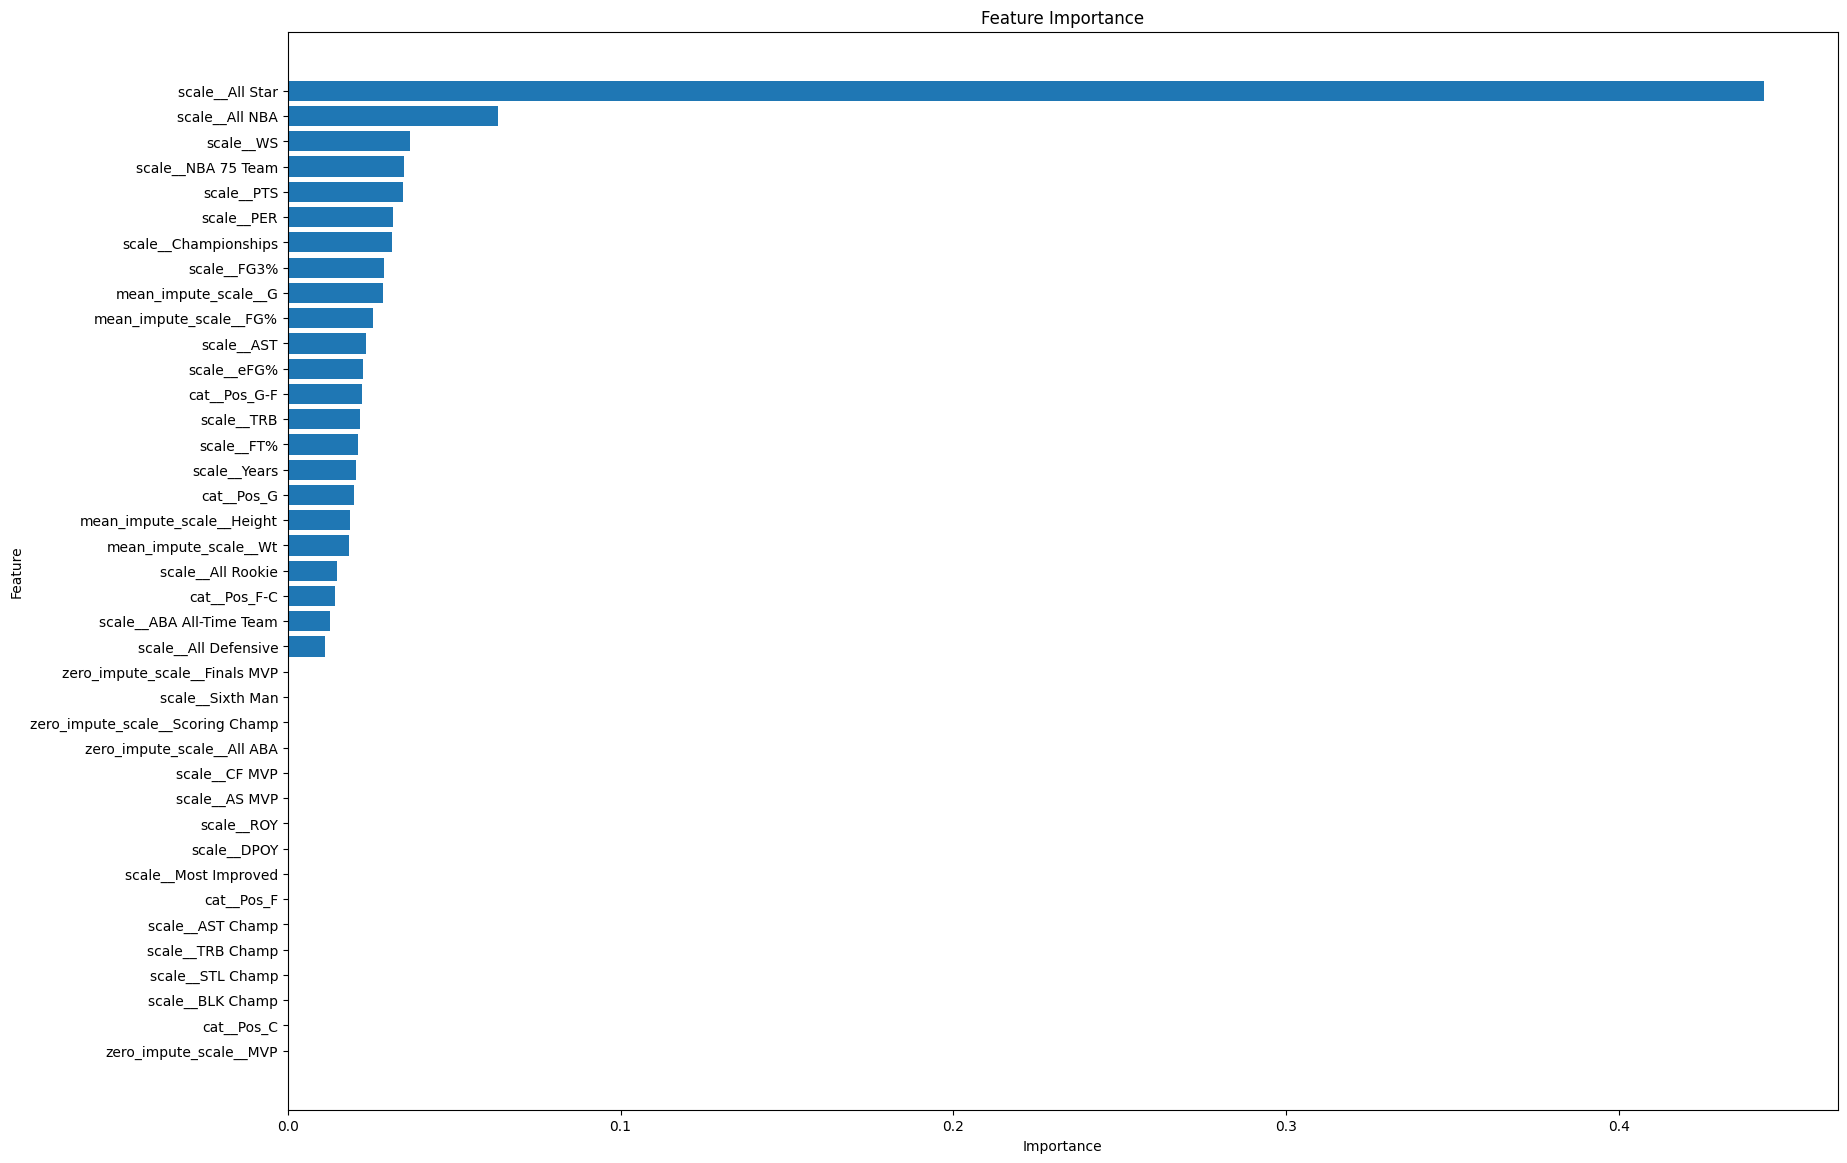

In [117]:
importances_df = pd.DataFrame({
    'feature': feature_names_after_preprocessing,
    'importance': best_model['classifier'].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(20, 14))
plt.barh(importances_df['feature'], importances_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

We can see that All Star appearances and All NBA teams are very important for players to be categorized as HOF. Pretty much all of the recent players the model detected as Hall of Famers. Surprisingly championships are the only the 7-th most important feature. When talking about the Greats of basketball, especially in debates, winning championships is looked at as one of the most (if not the most) important things.
Every championship team has some players with very poor performance that end up winning as part of the team, and that may negatively impact the effect championships won have on our classification task.

So, the prototypical Hall of Famer according to our model is a player with many All Star Game Appearances, All NBA teams, and that contributed to winning (WS refers to a statistical measure that measures a players' impact on the winning of his team). Finally, as we could expect, Hall of Famers have long careers.

Now we have a better understanding of the reason why a player like Draymond Green, who is projected to be a Hall of Famer after he retires, did not make the cut in this case.

In [118]:
specific_player_row = recent_df.loc[recent_df['Player'] == 'Draymond Green']
pd.set_option('display.max_columns', None)  # Ensures all columns are displayed
print(specific_player_row)
pd.reset_option('display.max_columns')

             Player  From    To  Years Pos   Ht  Height     Wt      G  PTS   
336  Draymond Green  2013  2022     10   F  6-6     NaN  230.0  685.0  8.7  \

     TRB  AST   FG%  FG3%   FT%  eFG%   PER    WS  All Star  All NBA  All ABA   
336  6.9  5.4  44.1  31.5  71.2  49.9  14.9  52.7         4        2      0.0  \

     All Rookie  All Defensive  BLK Champ  STL Champ  TRB Champ  AST Champ   
336           0              7          0          1          0          0  \

     Scoring Champ  Most Improved  Sixth Man  DPOY  ROY  AS MVP  CF MVP   
336            NaN              0          0     1    0       0       0  \

     Finals MVP  MVP  Championships  NBA 75 Team  ABA All-Time Team  HOF  
336         0.0  0.0              4            0                  0    0  


Draymond Green has been a multiple-time All star, and part of different All NBA teams and won many championships, but his personal stats are very bad. He does not even average 9 points per game, and he is shooting on very bad efficeincy. For that reason, the model probably does not classify him as a Hall of Famer.

It must also be noted that, when players are accepted into the hall of fame, their personal statistics and accolades are very important, but there are many other factors, such as popularity, that may impact a player's acceptance into the hall of fame.